In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import ali.methods
import ali.ui

In [2]:
for id in os.listdir('output/my'):
        if not "P" in id :continue
        
        hr,step,rhr,info=ali.methods.load(id)
        if info['covid_test_date']:
            print(f'{id}')
            break
        
#         alarms = pd.read_csv(f'output/my/{id}/alarm.csv',parse_dates=['datetime'],index_col='datetime').fillna(0)
#         alarms['datetime'] = pd.to_datetime(alarms['datetime'])
#         alarms = alarms.set_index('datetime')
#         if not os.path.isfile(f'output/my/{id}/rhr.h5'):
#             continue
        
#         rhr = pd.read_hdf(f'output/my/{id}/rhr.h5', 'rhr',mode='r')
        
#         display(rhr)



P476443


{'id': 'P476443', 'device': 'Fitbit', 'covid_test_date': Timestamp('2027-10-24 00:00:00'), 'symptom_date': Timestamp('2027-10-21 00:00:00')}


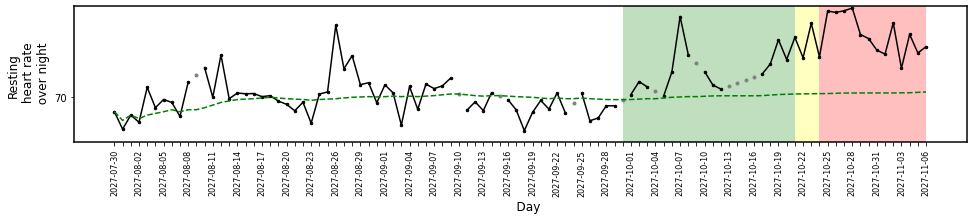

In [3]:
id='P476443'
seg='1T'

hr,step,rhr,info=ali.methods.load(id)
print(info)
ali.ui.plot(rhr,alerts=pd.DataFrame(),info=info,show=True)
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import json
import os
import compress_pickle
from sklearn.preprocessing import StandardScaler


def selectTrainTestSet(rhr, info):

    if info['covid_test_date']:
        dates_s = rhr.loc[(rhr.index < info['covid_test_date'] - pd.to_timedelta('21d'))].index.floor('1D').unique()
        dates_e = list(rhr.loc[(rhr.index > info['covid_test_date'] + pd.to_timedelta('21d'))].index.floor('1D').unique())
    else:
        dates_s = rhr.index.floor('1D').unique()
        dates_e = []
        
    dates_e.append(rhr.index[-1])

    s = min(28, len(dates_s))
    e = -min(28-s, len(dates_e))-1
    print(e)
    print(dates_e)
    train = rhr.loc[(rhr.index < dates_s[s]) | (rhr.index > dates_e[e])]
    test = rhr.loc[(rhr.index >= dates_s[s]) & (rhr.index <= dates_e[e])]

    return train, test


def preprocessing(train, test):
    # display(rhr)

    if os.path.isfile(f'ali/an_data/preprocess.pkl.lz41'):
        scaler = compress_pickle.load(f'ali/an_data/preprocess.pkl.lz4')
    else:
        scaler = StandardScaler()
        scaler = scaler.fit(train[['heartrate']])
        compress_pickle.dump(scaler, f'ali/an_data/preprocess.pkl.lz4')

    train = pd.DataFrame(scaler.transform(train),index=train.index,columns=train.columns)
    test = pd.DataFrame(scaler.transform(test),index=test.index,columns=test.columns)
    return train, test


def create_sequences(data, resolution, seg=1):
    data = data.resample(resolution).mean().dropna()
    dates = data.loc[data.index.hour < 7].dropna().resample('1D').count()
    min_acceptable_count = dates.loc[dates['heartrate'] > 0].mean().values[0]/4
    data['date'] = data.index.floor('1D')
    data['time'] = data.index.time
    day_time = data.set_index(['time', 'date']).unstack(level=0).droplevel(0, axis=1).interpolate(limit_direction='both', axis=1)
    out=[]
    for w in dates.rolling(window=f'{seg}D', closed='right'):
        if len(w)==seg and w.sum().values[0]>min_acceptable_count*seg:
            res = day_time.reindex(w.index).interpolate(limit_direction='both', axis=0).values
            out.append(np.reshape(res, (res.shape[0]*res.shape[1],1)))
#             out.append(res)
        
    return np.stack(out)


def createAutoEncoderModel(shape):
    model = keras.Sequential(
        [
            layers.Input(shape=(shape[1], shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    return model


def createLSTMModel(shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64,
        input_shape=(shape[1], shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(
        keras.layers.TimeDistributed(
            keras.layers.Dense(units=shape[2])
        )
    )
    model.compile(loss='mae', optimizer='adam')
    return model


In [4]:
model='auto-encoder'; resolution='1T'; seg=7
train, test = selectTrainTestSet(rhr, info)
train, test = preprocessing(train, test)

x_train = create_sequences(train, resolution, seg)
print("Training input shape: ", x_train.shape)
if os.path.isfile(f'ali/an_data/model-{model}-{seg}.h5'):
    model = tf.keras.models.load_model(f'ali/an_data/model-{model}-{seg}.h5')
else:
    if model == 'auto-encoder':
        model = createAutoEncoderModel(x_train.shape)
    else:
        model = createLSTMModel(x_train.shape)

# model.summary()
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

-1
[Timestamp('2027-11-06 06:59:48')]
Training input shape:  (23, 2940, 1)
Epoch 1/50
1/1 [==============================] - 1s 688ms/step - loss: 0.5937 - val_loss: 0.7720
Epoch 2/50
1/1 [==============================] - 0s 49ms/step - loss: 0.5831 - val_loss: 0.7532
Epoch 3/50
1/1 [==============================] - 0s 49ms/step - loss: 0.5726 - val_loss: 0.7327
Epoch 4/50
1/1 [==============================] - 0s 48ms/step - loss: 0.5611 - val_loss: 0.7105
Epoch 5/50
1/1 [==============================] - 0s 45ms/step - loss: 0.5493 - val_loss: 0.6853
Epoch 6/50
1/1 [==============================] - 0s 44ms/step - loss: 0.5342 - val_loss: 0.6569
Epoch 7/50
1/1 [==============================] - 0s 50ms/step - loss: 0.5184 - val_loss: 0.6255
Epoch 8/50
1/1 [==============================] - 0s 47ms/step - loss: 0.4998 - val_loss: 0.5910
Epoch 9/50
1/1 [==============================] - 0s 46ms/step - loss: 0.4811 - val_loss: 0.5538
Epoch 10/50
1/1 [==============================] - 

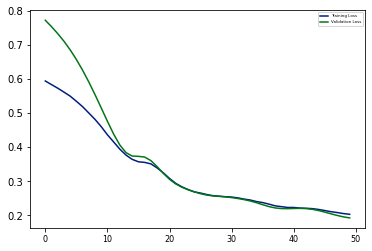

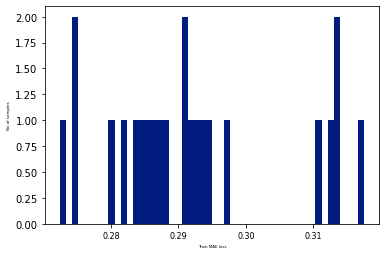

In [5]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

Reconstruction error threshold:  0.3175445758865079


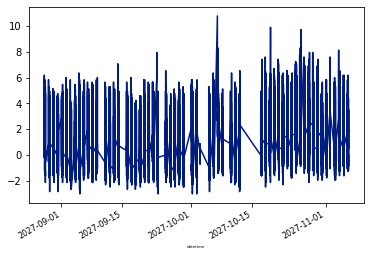

Test input shape:  (65, 2940, 1)


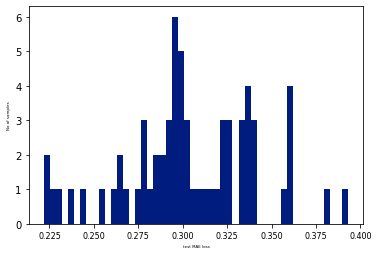

Number of anomaly samples:  24
Indices of anomaly samples:  (array([40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64]),)


In [6]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(test, seg=seg, resolution=resolution)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


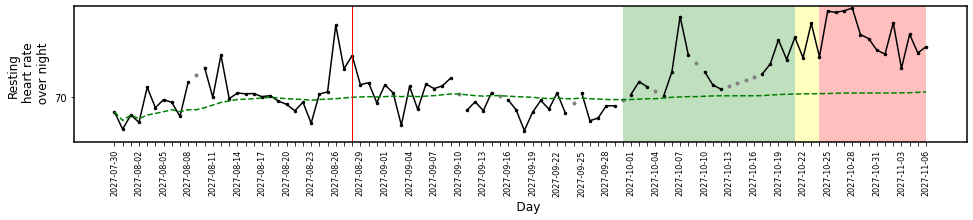

                     heartrate
datetime                      
2027-08-28 00:06:37   1.221632
2027-08-28 00:06:52   0.866648
2027-08-28 00:07:02   0.689156
2027-08-28 00:07:07   0.511664
2027-08-28 00:07:27   0.689156
2027-08-28 00:07:32   0.511664
2027-08-28 00:07:42   0.511664
2027-08-28 00:07:47   0.511664
2027-08-28 00:07:52   0.334172
2027-08-28 00:08:07   0.156680
2027-08-28 00:08:12   0.334172
2027-08-28 00:08:22   0.156680
2027-08-28 00:08:27  -0.020812
2027-08-28 00:08:32   0.334172
2027-08-28 00:08:42   0.156680
2027-08-28 00:08:57   0.334172
2027-08-28 00:09:12   0.334172
2027-08-28 00:09:27   0.511664
2027-08-28 00:09:37   0.511664
2027-08-28 00:09:42   0.334172
2027-08-28 00:09:47   0.156680
2027-08-28 00:10:02   0.156680
2027-08-28 00:10:17   0.156680
2027-08-28 00:10:32   0.156680


In [7]:

dates = test.iloc[np.where(anomalies)].resample('1D').count().fillna(0).rename(columns={'heartrate': 'count'})

dates['alarm'] = (dates['count'] > 0)*2
# return dates
ali.ui.plot(rhr,alerts=dates,info=info,show=True)
print(test.iloc[np.where(anomalies)])